# Imports

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd

# from matplotlib.colors import Lognorm
from scipy.integrate import simps
from time import time
import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipywidgets import interact
import seaborn as sns
sns.set(palette='colorblind', style='whitegrid')
sns.set_style({'font.family': ['serif']})
from matplotlib.colors import LogNorm, SymLogNorm

In [3]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
RBF = kernels.RBF
WhiteKernel = kernels.WhiteKernel

In [4]:
sys.path.append('../cf_analysis/')
import tools

import glearn
from rscm import RSCM
# from cf_analysis import pcalearn
from sklearn.decomposition import PCA
from svdanalysis import SVDlearn
import synth, kde, pcalearn
from pcalearn import PCAYJ

# from cf_analysis import kde
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
KernelRegression = kde.KernelRegression

import yjtransform as yjt


In [5]:
import json

# Setup

In [6]:

class GetObject(object):
    def __init__(self, *initial_data, **kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])           
            
    

In [7]:
data2 = pd.read_csv('../The_Tax_Burden_on_Tobacco__1970-2017.csv')
data2 = data2[data2['Year'] <=2000]
sales = data2[data2['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
statesid = data2['LocationAbbr'].unique()
statesales, statecosts = {}, {}
for ss in statesid:
    statesales[ss] = sales[sales['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']
taxstates = ['CA', 'MA', 'OR', 'FL', 'AZ']
controlstates = list(set(statesid) - set(sskip))
controls2 = np.array([statesales[ss] for ss in statesid if ss!= 'CA'])
#
data2 = pd.read_csv('../The_Tax_Burden_on_Tobacco__1970-2017.csv')
data2 = data2[data2['Year'] <=2005]
sales = data2[data2['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
statesid = data2['LocationAbbr'].unique()
statesales, statecosts = {}, {}
for ss in statesid:
    statesales[ss] = sales[sales['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']
taxstates = ['CA', 'MA', 'OR', 'FL', 'AZ']
controlstates = list(set(statesid) - set(sskip))
controls3 = np.array([statesales[ss] for ss in statesid if ss!= 'CA'])


In [8]:

# years = t           

data = pd.read_csv('../basque.csv')
years = data['year'].unique()
xplot = years.copy()            
T0 = np.where(years == 1970)[0][0]
years = years[:2*T0]
gdp = data['gdpcap'].values.reshape(18, -1)
gdp = gdp[1:, :2*T0]
treated = gdp[-2]
rr = data['regionname'].unique()[-2]
controls = np.append(gdp[:-2], gdp[-1:], axis=0)

X = gdp.copy()
N, T = X.shape[0], X.shape[1]
t = np.arange(T)
itreated = 15



# Load and plot

In [100]:
ttax2000 = {}
for ff in os.listdir('../tmpdata/prop99_2000/'):
    ttax2000[ff.split('.')[0]] = np.load('../tmpdata/prop99_2000/' + ff)
    
ttax2005 = {}
for ff in os.listdir('../tmpdata/prop99_2005/'):
    ttax2005[ff.split('.')[0]] = np.load('../tmpdata/prop99_2005/' + ff)
    
basque = {}
for ff in os.listdir('../tmpdata/basque//'):
    basque[ff.split('.')[0]] = np.load('../tmpdata/basque//' + ff)
    
    
itreated0 = 4
itreated1 = 15
years0 = np.arange(1970, 2001)
years1 = np.arange(1955, 1985)
years2 = np.arange(1970, 2006)
ivtreated0 = 1988
ivtreated1 = 1970
yyears = [years0, years1, years2]
itt = [itreated0, itreated1, itreated0]
ivt = [1988, 1970, 1988]
dds = [ttax2000, basque, ttax2005]


In [10]:
basque['pcafits95regnoise'].shape

(17, 3, 30)

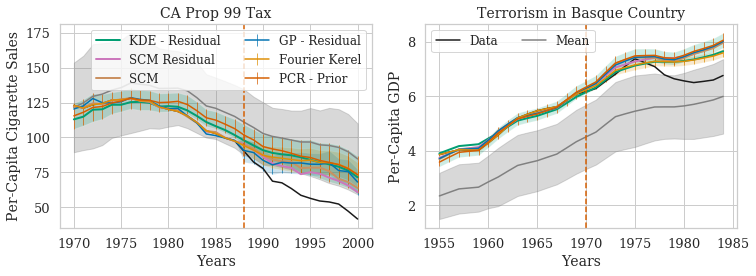

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 4))
fsize = 14

ppp = 95
labels = ['SCM', 'SCM Residual',  'PCR - Prior', 'KDE - Residual', 'Fourier Kerel', 'GP - Residual'][::-1]
# if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafits99regnoisepca, pcafitsyj99noisepca, kdefitsres, gpfitspca99res'
# elif ppp == 95: kkeys = 'scmfits, scmfitsres, pcafits95regnoisepca, pcafitsyj95noisepca, kdefitsres, gpfitspca95res'
# if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafits99regnoise, pcafitsyj99noise, kdefitsres, gpfitspca99res'
# elif ppp == 95: kkeys = 'scmfits, scmfitsres, pcafits95regnoise, pcafitsyj95noise, kdefitsres, gpfitspca95res'
if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafitsyj99noise, kdefitsres, glfits, gpfitspca99res'
elif ppp == 95: kkeys = 'scmfits, scmfitsres, pcafitsyj95noise, kdefitsres, glfits, gpfitspca95res'
kkeys = kkeys.split(', ')[::-1]

for ik, kk in enumerate(kkeys):
    dd1 = basque[kk]
    dd0 = ttax2000[kk]
    dd = [dd0, dd1]

    for i in range(2):
        lbl, lblm = None, None

        mm = np.concatenate([dd[i][:itt[i]], dd[i][itt[i]+1:]]).mean(axis=0)[0]
        stds = np.concatenate([dd[i][:itt[i]], dd[i][itt[i]+1:]]).std(axis=0)[0]
        if i : lbl = 'Data'
        if ik == 0: ax[i].plot(yyears[i], dd[i][itt[i]][0], 'k', label=lbl)
        if i : lbl = 'Mean'
        if ik == 0:  
            ax[i].plot(yyears[i], mm, 'gray', label=lbl)
            ax[i].fill_between(yyears[i], mm - stds, mm + stds, color='gray', alpha=0.3)

        if i == 0 : lblm = labels[ik]
        try: 
            ax[i].errorbar(yyears[i], dd[i][itt[i]][1], dd[i][itt[i]][2], label = lblm, elinewidth=0.7)
            ax[i].fill_between(yyears[i], dd[i][itt[i]][1] - dd[i][itt[i]][2], dd[i][itt[i]][1] + dd[i][itt[i]][2], alpha=0.2)
        except : ax[i].plot(yyears[i], dd[i][itt[i]][1], label = lblm, lw=2)


for axis in ax : 
    axis.legend(fontsize=fsize-2, ncol=2)
    axis.tick_params(labelsize=fsize-1)
    axis.set_xlabel('Years', fontsize=fsize)
ax[0].axvline(1988, color='r', ls="--")
ax[1].axvline(1970, color='r', ls="--")
ax[0].set_ylabel('Per-Capita Cigarette Sales', fontsize=fsize)
ax[1].set_ylabel('Per-Capita GDP', fontsize=fsize)
ax[0].set_title('CA Prop 99 Tax', fontsize=fsize)
ax[1].set_title('Terrorism in Basque Country', fontsize=fsize)
plt.tight_layout()
# if ppp == 99:
#     plt.savefig('../new_figs/cf99.png')
#     plt.savefig('../new_figs/cf99.pdf')
# elif ppp == 95:
#     plt.savefig('../new_figs/cf95.png')
#     plt.savefig('../new_figs/cf95.pdf')

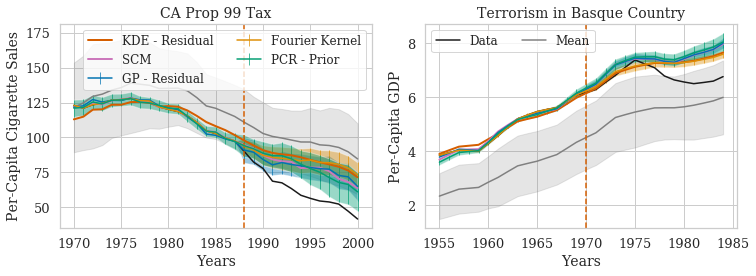

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 4))
fsize = 14

ppp = 95
labels = ['SCM',  'KDE - Residual',  'PCR - Prior', 'Fourier Kernel', 'GP - Residual'][::-1]
# if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafits99regnoisepca, pcafitsyj99noisepca, kdefitsres, gpfitspca99res'
# elif ppp == 95: kkeys = 'scmfits, scmfitsres, pcafits95regnoisepca, pcafitsyj95noisepca, kdefitsres, gpfitspca95res'
kkeys = 'scmfits, kdefitsres, pcafitsyj99noise, glfits, gpfitspca99res'
# kkeys = 'pcafitsyj95noise, pcafitsyj99noise'
kkeys = kkeys.split(', ')[::-1]

for ik, kk in enumerate(kkeys):
    dd1 = basque[kk]
    dd0 = ttax2000[kk]
    dd = [dd0, dd1]

    for i in range(2):
        lbl, lblm = None, None

        mm = np.concatenate([dd[i][:itt[i]], dd[i][itt[i]+1:]]).mean(axis=0)[0]
        stds = np.concatenate([dd[i][:itt[i]], dd[i][itt[i]+1:]]).std(axis=0)[0]
        if i : lbl = 'Data'
        if ik == 0: ax[i].plot(yyears[i], dd[i][itt[i]][0], 'k', label=lbl)
        if i : lbl = 'Mean'
        if ik == 0:  
            ax[i].plot(yyears[i], mm, 'gray', label=lbl)
            ax[i].fill_between(yyears[i], mm - stds, mm + stds, color='gray', alpha=0.2)

        if i == 0 : lblm = labels[ik]
        try: 
            ax[i].errorbar(yyears[i], dd[i][itt[i]][1], dd[i][itt[i]][2], label = lblm, elinewidth=0.7)
            ax[i].fill_between(yyears[i], dd[i][itt[i]][1] - dd[i][itt[i]][2], dd[i][itt[i]][1] + dd[i][itt[i]][2], alpha=0.4)
        except : ax[i].plot(yyears[i], dd[i][itt[i]][1], label = lblm, lw=2)


for axis in ax : 
    axis.legend(fontsize=fsize-2, ncol=2)
    axis.tick_params(labelsize=fsize-1)
    axis.set_xlabel('Years', fontsize=fsize)
ax[0].axvline(1988, color='r', ls="--")
ax[1].axvline(1970, color='r', ls="--")
ax[0].set_ylabel('Per-Capita Cigarette Sales', fontsize=fsize)
ax[1].set_ylabel('Per-Capita GDP', fontsize=fsize)
ax[0].set_title('CA Prop 99 Tax', fontsize=fsize)
ax[1].set_title('Terrorism in Basque Country', fontsize=fsize)
plt.tight_layout()
# plt.savefig('../new_figs/cf.png')
# plt.savefig('../new_figs/cf.pdf')


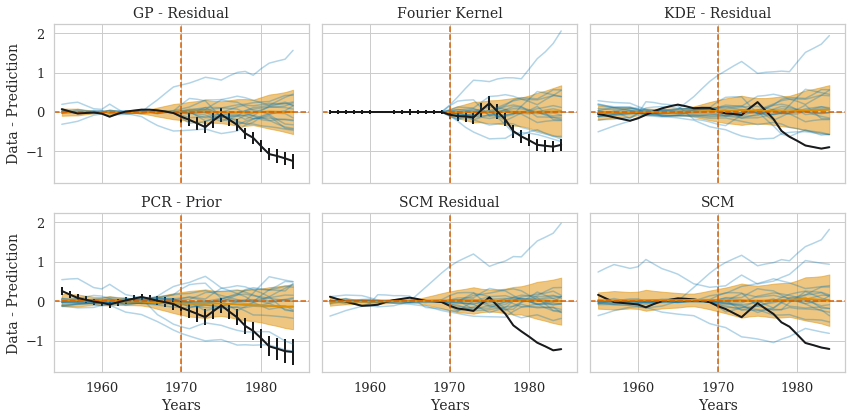

In [96]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

labels = ['SCM', 'SCM Residual', 'PCR - Prior', 'KDE - Residual',  'Fourier Kernel', 'GP - Residual'][::-1]
ppp = 95
# kkeys = 'scmfits, scmfitsres, pcafits95, pcafitsyj95, kdefitsres, gpfitsres'
# kkeys = 'scmfits, scmfitsres, pcafits99, pcafitsyj99, kdefitsres, gpfitsres'
# if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafits99regnoisepca, pcafitsyj99noisepca, kdefitsres, gpfitspca99res'
# elif ppp == 95: kkeys = 'scmfits, scmfitsres, pcafits95regnoisepca, pcafitsyj95noisepca, kdefitsres, gpfitspca95res'
# kkeys = 'scmfits, scmfitsres, pcafitsyj95noise, pcafitsyj99noise, kdefitsres, gpfitspca99res'
kkeys = 'scmfits, scmfitsres, pcafitsyj99noise, kdefitsres, glfits, gpfitspca99res'
# kkeys = 'scmfits, scmfitsres, pcafits99, pcafitsyj99noise, kdefitsres, gpfitspca99res'
kkeys = kkeys.split(', ')[::-1]

i = 1

for ik, kk in enumerate(kkeys):
    
    axis = ax.flatten()[ik]
    dd =  basque[kk]
    xx = yyears[i]
    diff = dd[:, 0] - dd[:, 1]
    axis.plot(xx, diff.T, 'C0', alpha=0.3)

    try: axis.errorbar(xx, diff[itt[i]], dd[itt[i]][2], color= 'k', lw=2)
    except:     axis.plot(xx, diff[itt[i]], 'k', lw=2)

    mmean, sstd = diff.mean(axis=0), diff.std(axis=0)
    axis.plot(xx, mmean, 'C1', lw=2)
    axis.fill_between(xx, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(labels[ik], fontsize=fsize)
    axis.axhline(0, color='r', ls="--")
    axis.axvline(ivt[i], color='r', ls="--")
    axis.set_xlim(1954, 1986)
    
for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
for axis in ax[1]:axis.set_xlabel('Years', fontsize=fsize)
for axis in ax[:, 0]:axis.set_ylabel('Data - Prediction', fontsize=fsize)
plt.tight_layout()
# plt.savefig('../new_figs/basque_all.png')    
# plt.savefig('../new_figs/basque_all.pdf')    
# if ppp == 99:
#     plt.savefig('../new_figs/basque_all99.png')    
#     plt.savefig('../new_figs/basque_all99.pdf')    
# elif ppp == 95:
#     plt.savefig('../new_figs/basque_all95.png')    
#     plt.savefig('../new_figs/basque_all95.pdf')    

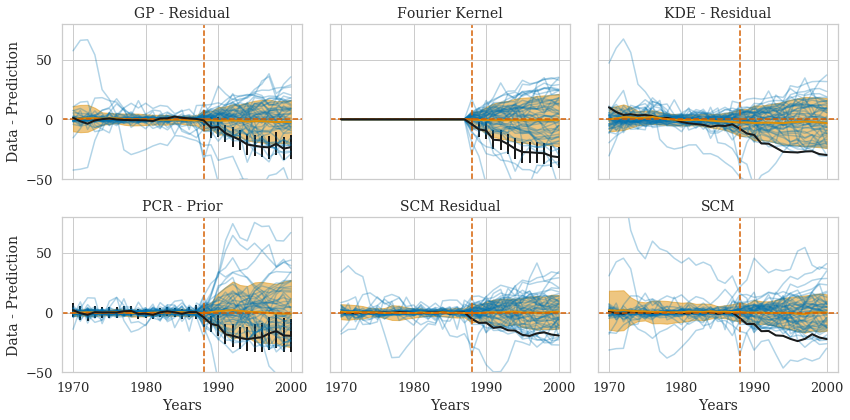

In [98]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

ppp = 95

labels = ['SCM', 'SCM Residual', 'PCR - Prior', 'KDE - Residual',  'Fourier Kernel', 'GP - Residual'][::-1]
ppp = 95
# kkeys = 'scmfits, scmfitsres, pcafits95, pcafitsyj95, kdefitsres, gpfitsres'
# kkeys = 'scmfits, scmfitsres, pcafits99, pcafitsyj99, kdefitsres, gpfitsres'
# if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafits99regnoisepca, pcafitsyj99noisepca, kdefitsres, gpfitspca99res'
# elif ppp == 95: kkeys = 'scmfits, scmfitsres, pcafits95regnoisepca, pcafitsyj95noisepca, kdefitsres, gpfitspca95res'
# kkeys = 'scmfits, scmfitsres, pcafitsyj95noise, pcafitsyj99noise, kdefitsres, gpfitspca99res'
kkeys = 'scmfits, scmfitsres, pcafitsyj99noise, kdefitsres, glfits, gpfitspca99res'
# kkeys = 'scmfits, scmfitsres, pcafits99, pcafitsyj99noise, kdefitsres, gpfitspca99res'
kkeys = kkeys.split(', ')[::-1]

i = 0

for ik, kk in enumerate(kkeys):
    
    axis = ax.flatten()[ik]
    dd =  ttax2000[kk]
    xx = yyears[i]
    diff = dd[:, 0] - dd[:, 1]
    axis.plot(xx, diff.T, 'C0', alpha=0.3)

    try: axis.errorbar(xx, diff[itt[i]], dd[itt[i]][2], color= 'k', lw=2)
    except:     axis.plot(xx, diff[itt[i]], 'k', lw=2)

    mmean, sstd = diff.mean(axis=0), diff.std(axis=0)
    axis.plot(xx, mmean, 'C1', lw=2)
    axis.fill_between(xx, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(labels[ik], fontsize=fsize)
    axis.axhline(0, color='r', ls="--")
    axis.axvline(ivt[i], color='r', ls="--")
    axis.set_ylim(-50, 80)

for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
for axis in ax[1]:axis.set_xlabel('Years', fontsize=fsize)
for axis in ax[:, 0]:axis.set_ylabel('Data - Prediction', fontsize=fsize)
plt.tight_layout()
# plt.savefig('../new_figs/ca_all.png')    
# plt.savefig('../new_figs/ca_all.pdf')    
# if ppp == 99:
#     plt.savefig('../new_figs/ca_all99.png')    
#     plt.savefig('../new_figs/ca_all99.pdf')    
# elif ppp == 95:
#     plt.savefig('../new_figs/ca_all95.png')    
#     plt.savefig('../new_figs/ca_all95.pdf')    

In [15]:
 dds[0]['pcapreds'][6][2]

array([ 9.07898022,  6.96094286,  6.82377691,  6.70437202,  7.08951917,
        7.25678971,  7.06763707,  6.86541852,  6.47236867,  5.71020589,
        5.4775432 ,  5.16971458,  5.55274982,  6.16136808,  5.25298417,
        7.09283358,  5.94322968,  8.78592295, 13.69586638, 17.7140711 ,
       33.46310079, 37.00159876, 45.66285928, 40.46666853, 37.91691928,
       42.90469339, 44.88298717, 50.92542475, 53.16772259, 53.99726958,
       51.99117958])

<ErrorbarContainer object of 3 artists>

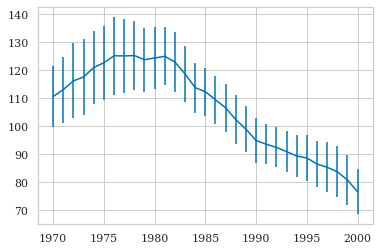

In [16]:
plt.errorbar(yyears[0], dds[0]['pcapreds'][0][1], dds[0]['pcapreds'][0][2])

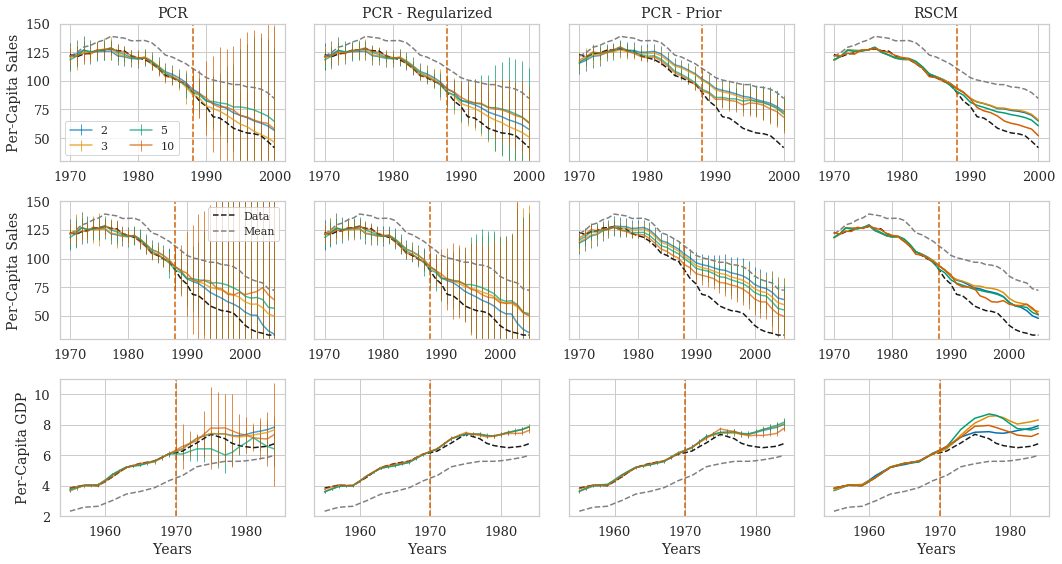

In [102]:
fig, ax = plt.subplots(3, 4, figsize=(15, 8), sharex='row', sharey='row')
fsize = 14
labels = ['PCR', 'PCR - Regularized', 'PCR - Prior',  'RSCM']
# kkeys = 'pcapreds, pcapredsregnoise, pcapredsyjnoise, svdpreds'
kkeys = 'pcapreds, pcapredsregnoise, pcapredsyjnoise, svdpreds'
# kkeys = 'pcapreds, pcapredsreg, pcapredsyj, svdpreds'
kkeys = kkeys.split(', ')

i = 0

for i in range(3):
    for ik, kk in enumerate(kkeys):
        axis = ax[i, ik]
        if i == 1: axis = ax[2, ik]
        if i == 2: axis = ax[1, ik]
        dd =  dds[i][kk]
        mm = np.concatenate([dds[i]['scmfits'][:itt[i]], dds[i]['scmfits'][itt[i]+1:]]).mean(axis=0)[0]
        xx = yyears[i]
        lbl = None
        if i == 2 and ik==0: lbl = "Data"
        axis.plot(xx, dd[0, 0], 'k', ls="--", label=lbl)
        if i == 2 and ik == 0: lbl = "Mean"
        axis.plot(xx, mm, 'gray', ls="--", label=lbl)
        lbl = None
#         for ncomp in range(1, 5):
        for ncomp in [2, 3, 5, 10]:
            if (i == 0) & (ik == 0) : lbl = ncomp
            try: axis.errorbar(xx+ncomp*0, dd[ncomp-1, 1], dd[ncomp-1, 2], label=lbl, elinewidth=1, alpha=0.7)
            except Exception as e:
                axis.plot(xx, dd[ncomp-1, 1], label=lbl)

        if i == 0 : axis.set_title(labels[ik], fontsize=fsize)
        axis.axvline(ivt[i], color='r', ls="--")

#     try: axis.errorbar(xx, diff[itt[i]], dd[itt[i]][2], color= 'k', lw=2)
#     except:     axis.plot(xx, diff[itt[i]], 'k', lw=2)
#     axis.set_ylim(-50, 80)

for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
for axis in ax[-1]:axis.set_xlabel('Years', fontsize=fsize)
# for axis in ax.flatten(): axis.legend(ncol=2)
ax[1, 0].legend(ncol=1)
ax[0, 0].legend(ncol=2)
ax[0, 0].set_ylim(30, 150)
ax[1, 0].set_ylim(30, 150)
ax[-1, 0].set_ylim(2, 11)
ax[0, 0].set_ylabel('Per-Capita Sales', fontsize=fsize)
ax[1, 0].set_ylabel('Per-Capita Sales', fontsize=fsize)
ax[2, 0].set_ylabel('Per-Capita GDP', fontsize=fsize)
# for axis in ax[:, 0]:axis.set_ylabel('Data - Prediction', fontsize=fsize)
plt.tight_layout()
# plt.savefig('../new_figs/pca.png')    
# plt.savefig('../new_figs/pca.pdf')    
# plt.savefig('../new_figs/pcanoise.png')    
# plt.savefig('../new_figs/pcanoise.pdf')    
# plt.savefig('../new_figs/pcanoisepca.png')    
# plt.savefig('../new_figs/pcanoisepca.pdf')    

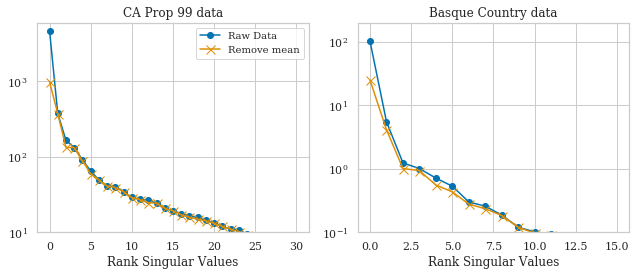

In [18]:
fsize = 12
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(np.linalg.svd(controls2)[1], marker='o', label='Raw Data')
ax[0].plot(np.linalg.svd(controls2 - controls2.mean(axis=0))[1], marker='x', label='Remove mean', markersize=9)
# ax[2].plot(np.linalg.svd(controls3)[1], marker='o', label='Raw Data')
# ax[2].plot(np.linalg.svd(controls - controls2.mean(axis=0))[1], marker='x', label='Remove mean', markersize=9)

ax[1].plot(np.linalg.svd(controls)[1], marker='o')
ax[1].plot(np.linalg.svd(controls - controls.mean(axis=0))[1], marker='x', markersize=9)
ax[0].set_ylim(10, 6000)
ax[1].set_ylim(0.1, 200)
ax[0].set_title('CA Prop 99 data', fontsize=fsize)
ax[1].set_title('Basque Country data', fontsize=fsize)
ax[0].legend(fontsize=fsize-2)
for axis in ax: 
    axis.set_yscale('log')
    axis.set_xlabel('Rank Singular Values', fontsize=fsize)
    axis.tick_params(labelsize=fsize-1)
plt.tight_layout()
# plt.savefig('../new_figs/svalues.png')
# plt.savefig('../new_figs/svalues.pdf')

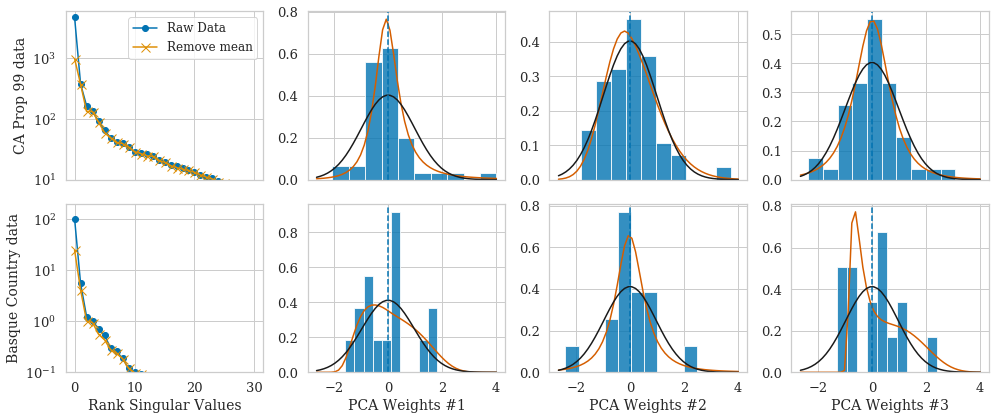

In [19]:
fsize = 14
nbins = 10 
normed = True
fig, axar = plt.subplots(2, 4, figsize=(14, 6), sharex="col")

ax = axar[:, 0]
ax[0].plot(np.linalg.svd(controls2)[1], marker='o', label='Raw Data')
ax[0].plot(np.linalg.svd(controls2 - controls2.mean(axis=0))[1], marker='x', label='Remove mean', markersize=9)
# ax[2].plot(np.linalg.svd(controls3)[1], marker='o', label='Raw Data')
# ax[2].plot(np.linalg.svd(controls - controls2.mean(axis=0))[1], marker='x', label='Remove mean', markersize=9)

ax[1].plot(np.linalg.svd(controls)[1], marker='o')
ax[1].plot(np.linalg.svd(controls - controls.mean(axis=0))[1], marker='x', markersize=9)
ax[0].set_ylim(10, 6000)
ax[1].set_ylim(0.1, 200)
ax[0].set_ylabel('CA Prop 99 data', fontsize=fsize)
ax[1].set_ylabel('Basque Country data', fontsize=fsize)
ax[0].legend(fontsize=fsize-2)

pca = PCA(5, whiten=True).fit(controls - controls.mean(axis=0))
pca2 = PCA(5, whiten=True).fit(controls2 - controls2.mean(axis=0))
pt = pca.transform(controls - controls.mean(axis=0))
pt2 = pca2.transform(controls2 - controls2.mean(axis=0))
xx = np.linspace(pt2.min(), pt2.max())

for ia, axis in enumerate(axar[0, 1:]):
    axis.hist(pt2[:, ia], bins=nbins, density=normed, alpha=0.8)
    pp = yjt.get_transform(pt2[:, ia])
    qq = yjt.getpdf(xx, pp)
    axis.plot(xx, qq, 'r')
    pp = tools.fitgausspdf(pt2[:, ia], normalized=True, verbose=0)    
    axis.plot(xx, tools.logpdf_gauss(xx, *pp, rety=True), 'k')    
    axis.axvline(0, ls="--")
    
for ia, axis in enumerate(axar[1, 1:]):
    axis.hist(pt[:, ia], bins=nbins, density=normed, alpha=0.8)
    pp = yjt.get_transform(pt[:, ia])
    qq = yjt.getpdf(xx, pp)
    axis.plot(xx, qq, 'r')
    pp = tools.fitgausspdf(pt[:, ia], normalized=True, verbose=0)    
    axis.plot(xx, tools.logpdf_gauss(xx, *pp, rety=True), 'k')    
    axis.axvline(0, ls="--")

axar[1, 0].set_xlabel('Rank Singular Values', fontsize=fsize)
for ia in range(1, 4): axar[1, ia].set_xlabel('PCA Weights #%d'%ia, fontsize=fsize)
for axis in axar[:, 0]: axis.set_yscale('log')
for axis in axar.flatten(): axis.tick_params(labelsize=fsize-1)
plt.tight_layout()


# plt.savefig('../new_figs/svalues2.png')
# plt.savefig('../new_figs/svalues2.pdf')

# Load and plot experiments 

In [21]:
os.listdir('../tmpdata/')

['xu_nf2_fixed',
 'pcamix_3mix_3freq_noeigv',
 'pcamix_10mix_3freq_noeigv_30_s100',
 'xu_fac2_fixed',
 'prop99_2005',
 'sinecos_c10_s10_ranload_samephase',
 'pcamix_10mix_3freq_noeigv_50_s200',
 'pcamix_3mix_3freq_noeigv_50_s1',
 'sinecos_c2_s2_ranload_ranphase',
 'sinecos_c10_s10_ranload_ranphase',
 'prop99_2000',
 'xu_fac10_fixed',
 'xu_nf20_fixed',
 'basque',
 'sinecos_c10_s10_ranload_samephase_v2',
 'sinecos_c5_s5_ranload_ranphase',
 'sinecos_c2_s2_ranload_samephase',
 'pcamix_10mix_3freq_noeigv_nonoise_50_s100',
 'sinecos_c2_s2_diffload_ranphase',
 'pcamix_3mix_3freq',
 'pcamix_3mix_3freq_noeigv_50_s11']

In [22]:
xu2, xu20 = {}, {}

for d, fname in [[xu2, '../tmpdata/xu_nf2_fixed//'], [xu20, '../tmpdata/xu_nf20_fixed//']]:
    for ff in os.listdir(fname):
        try: d[ff.split('.')[0]] = np.load(fname + ff)
        except Exception as e:
            print(e)
            print(ff)
    print(fname, len(d.keys()))
    
cs22s, cs22r, cs1010s, cs1010r = {}, {}, {}, {}
for d, fname in [[cs22s, '../tmpdata/sinecos_c2_s2_ranload_samephase/'], [cs1010s, '../tmpdata/sinecos_c10_s10_ranload_samephase_v2/'], 
                 [cs22r, '../tmpdata/sinecos_c2_s2_ranload_ranphase//'], [cs1010r, '../tmpdata/sinecos_c10_s10_ranload_ranphase/']]:
    for ff in os.listdir(fname):
        try: d[ff.split('.')[0]] = np.load(fname + ff)
        except Exception as e:
            print(e)
            with open (fname + ff) as file:  print(file.read())
    print(fname, len(d.keys()))
    
pcmeig, pcm50v2, pcm30, pcm50 = {}, {}, {}, {}
pcm10mix50, pcm10mix30, pcm10mix50nonoise = {}, {}, {}
for d, fname in [[pcmeig, '../tmpdata/pcamix_3mix_3freq//'], [pcm50v2, '../tmpdata/pcamix_3mix_3freq_noeigv_50_s11//'], 
                 [pcm30, '../tmpdata/pcamix_3mix_3freq_noeigv//'], [pcm50, '../tmpdata/pcamix_3mix_3freq_noeigv//'],
                [pcm10mix50, '../tmpdata/pcamix_10mix_3freq_noeigv_50_s200//'], [pcm10mix30, '../tmpdata/pcamix_10mix_3freq_noeigv_30_s100//'],
                [pcm10mix50nonoise, '../tmpdata/pcamix_10mix_3freq_noeigv_nonoise_50_s100/']]:
    for ff in os.listdir(fname):
        try: d[ff.split('.')[0]] = np.load(fname + ff)
        except Exception as e:
            print(e)
            with open (fname + ff) as file:  print(file.read())
    print(fname, len(d.keys()))

# ttax2005 = {}
# for ff in os.listdir('../tmpdata/prop99_2005/'):
#     ttax2005[ff.split('.')[0]] = np.load('../tmpdata/prop99_2005/' + ff)
    
# basque = {}
# for ff in os.listdir('../tmpdata/basque//'):
#     basque[ff.split('.')[0]] = np.load('../tmpdata/basque//' + ff)
    
    
# itreated0 = 4
# itreated1 = 15
# years0 = np.arange(1970, 2001)
# years1 = np.arange(1955, 1985)
# years2 = np.arange(1970, 2006)
# ivtreated0 = 1988
# ivtreated1 = 1970
# yyears = [years0, years1, years2]
# itt = [itreated0, itreated1, itreated0]
# ivt = [1988, 1970, 1988]
# dds = [ttax2000, basque, ttax2005]


Cannot load file containing pickled data when allow_pickle=False
dgpdict.txt
../tmpdata/xu_nf2_fixed// 60
Cannot load file containing pickled data when allow_pickle=False
dgpdict.txt
../tmpdata/xu_nf20_fixed// 60
Cannot load file containing pickled data when allow_pickle=False
{'cosfreq': array([1.12553301, 1.58048674]), 'fix': 1, 'generate': <bound method SineCosSim.generate of <__main__.SineCosSim object at 0x7fb6d9dd8cd0>>, 'loadings': 'random', 'monoamp': 1, 'noise': 0.1, 'phases': 'same', 'seed': 1, 'sinfreq': array([0.50017156, 0.95349886])}
../tmpdata/sinecos_c2_s2_ranload_samephase/ 62
Cannot load file containing pickled data when allow_pickle=False
{'cosfreq': array([1.31510741, 0.91755408, 1.13677639, 1.7671642 , 0.50707828,
       0.68235368, 1.50612363, 1.73877913, 0.70505988, 1.36263999]), 'fix': 1, 'generate': <bound method SineCosSim.generate of <__main__.SineCosSim object at 0x7fb6d062b690>>, 'loadings': 'random', 'monoamp': 2, 'noise': 0.3, 'phases': 'same', 'seed': 10

In [23]:
'glfits' in cs22s.keys()

True

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


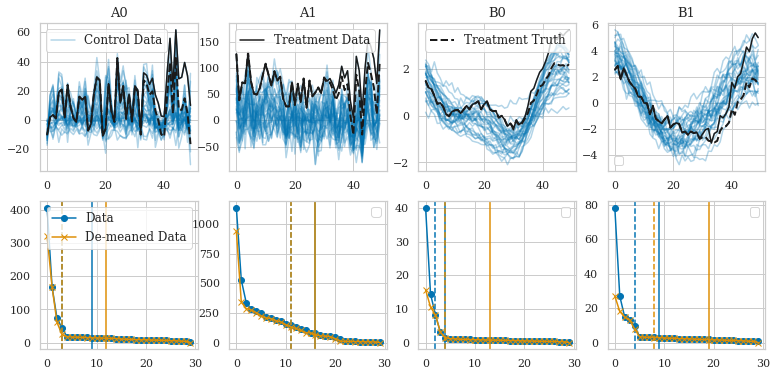

In [24]:
fsize=12
fig, ax = plt.subplots(2, 4, figsize = (13, 6), sharex='row')

titles = ['A0', 'A1', 'B0', 'B1']
# for idd, dd in enumerate([xu2, xu20, cs22s, cs1010s]):
for idd, dd in enumerate([xu2, xu20, cs22s, cs1010s]):
    
    lbl, lbl1, lbl2 = None, None, None
    ax[0, idd].plot(dd['data'].T, 'C0', alpha=0.3)
    if not idd: 
        lbl = 'Control Data'
        ax[0, idd].plot(dd['data'][0], 'C0', alpha=0.3, label=lbl)
    if idd==1: lbl1 = 'Treatment Data'
    ax[0, idd].plot(dd['data'][0], 'k-', label=lbl1)
    if idd==2: lbl2 = 'Treatment Truth'
    ax[0, idd].plot(dd['cf'][0], 'k--', lw=2, label=lbl2)
    
    if not idd: lbl = 'Data'
    ax[1, idd].plot(np.linalg.svd(dd['data'])[1][:], marker='o', label=lbl)
    ax[1, idd].axvline(tools.approximate_rank(dd['data'], 0.95), color='C0', ls="--")
    ax[1, idd].axvline(tools.approximate_rank(dd['data'], 0.99), color='C0', ls="-")
    if not idd: lbl = 'De-meaned Data'
    ax[1, idd].plot(np.linalg.svd(dd['data'] - dd['data'].mean(axis=0))[1][:], marker='x', label=lbl)
    ax[1, idd].axvline(tools.approximate_rank(dd['data'] - dd['data'].mean(axis=0), 0.95), color='C1', ls="--")
    ax[1, idd].axvline(tools.approximate_rank(dd['data'] - dd['data'].mean(axis=0), 0.99), color='C1', ls="-")

    ax[0, idd].set_title(titles[idd], fontsize=fsize+1)
    for axis in ax.flatten(): axis.legend(fontsize=fsize)
for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
# plt.savefig('../new_figs/simdata.png')
# plt.savefig('../new_figs/simdata.pdf')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


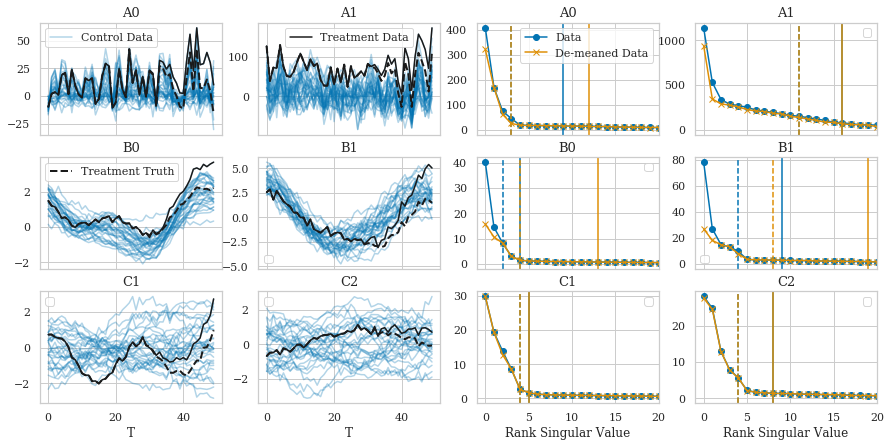

In [71]:
fsize=12
fig, ax = plt.subplots(3, 4, figsize = (15, 7), sharex='col')

titles = ['A0', 'A1', 'B0', 'B1', 'C1', 'C2']
# for idd, dd in enumerate([xu2, xu20, cs22s, cs1010s]):
for idd, dd in enumerate([xu2, xu20, cs22s, cs1010s, pcm50, pcm10mix30]):
    
    lbl, lbl1, lbl2 = None, None, None
    ax[idd//2, idd%2].plot(dd['data'].T, 'C0', alpha=0.3)
    if not idd: 
        lbl = 'Control Data'
        ax[0, idd].plot(dd['data'][0], 'C0', alpha=0.3, label=lbl)
    if idd==1: lbl1 = 'Treatment Data'
    ax[idd//2, idd%2].plot(dd['data'][0], 'k-', label=lbl1)
    if idd==2: lbl2 = 'Treatment Truth'
    ax[idd//2, idd%2].plot(dd['cf'][0], 'k--', lw=2, label=lbl2)
    ax[idd//2, idd%2].set_title(titles[idd], fontsize=fsize+1)
    
    if not idd: lbl = 'Data'
    ax[idd//2, idd%2+2].plot(np.linalg.svd(dd['data'])[1][:], marker='o', label=lbl)
    ax[idd//2, idd%2+2].axvline(tools.approximate_rank(dd['data'], 0.95), color='C0', ls="--")
    ax[idd//2, idd%2+2].axvline(tools.approximate_rank(dd['data'], 0.99), color='C0', ls="-")
    if not idd: lbl = 'De-meaned Data'
    ax[idd//2, idd%2+2].plot(np.linalg.svd(dd['data'] - dd['data'].mean(axis=0))[1][:], marker='x', label=lbl)
    ax[idd//2, idd%2+2].axvline(tools.approximate_rank(dd['data'] - dd['data'].mean(axis=0), 0.95), color='C1', ls="--")
    ax[idd//2, idd%2+2].axvline(tools.approximate_rank(dd['data'] - dd['data'].mean(axis=0), 0.99), color='C1', ls="-")
    ax[idd//2, idd%2+2].set_title(titles[idd], fontsize=fsize+1)
    
for axis in ax[:, 2:].flatten(): axis.set_xlim(-1, 20)
for axis in ax.flatten() :
    axis.tick_params(labelsize=fsize-1, rotation=0)
    axis.legend()
for axis in ax[-1, :2]: axis.set_xlabel('T', fontsize=fsize)    
for axis in ax[-1, 2:]: axis.set_xlabel('Rank Singular Value', fontsize=fsize)    
# plt.savefig('../new_figs/simdata2.png')
# plt.savefig('../new_figs/simdata2.pdf')

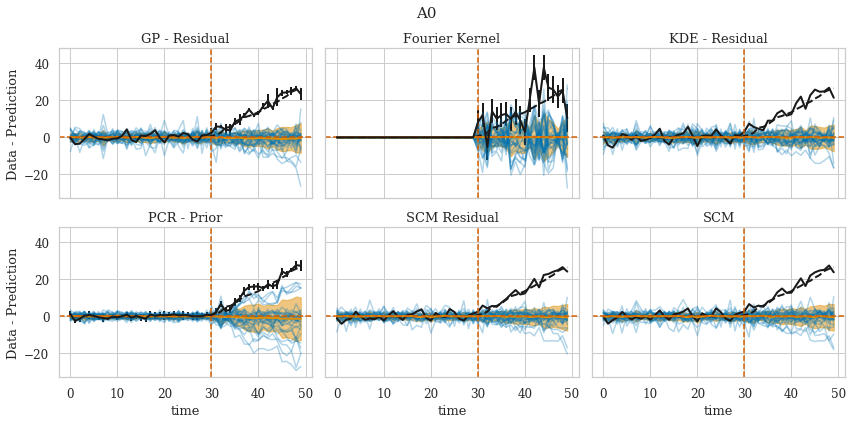

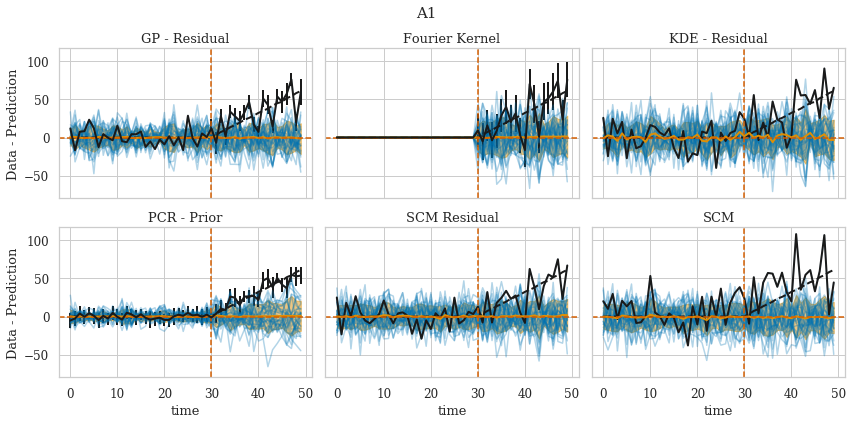

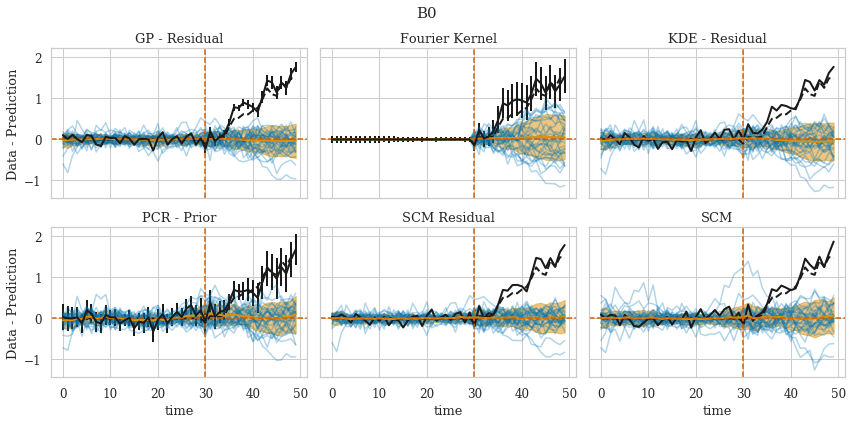

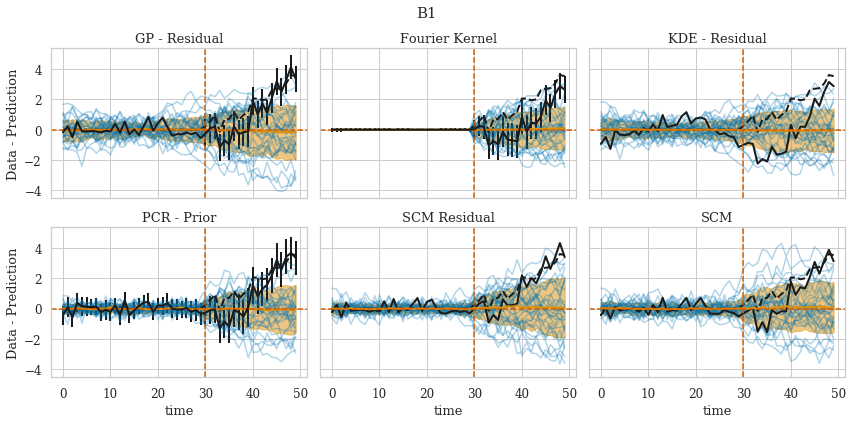

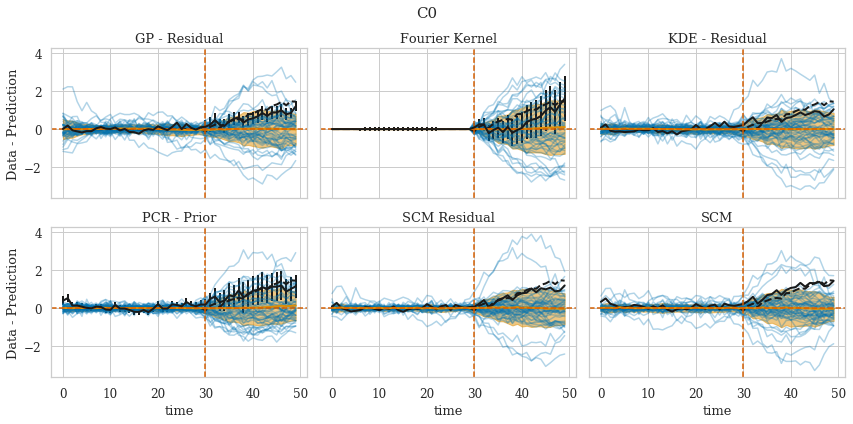

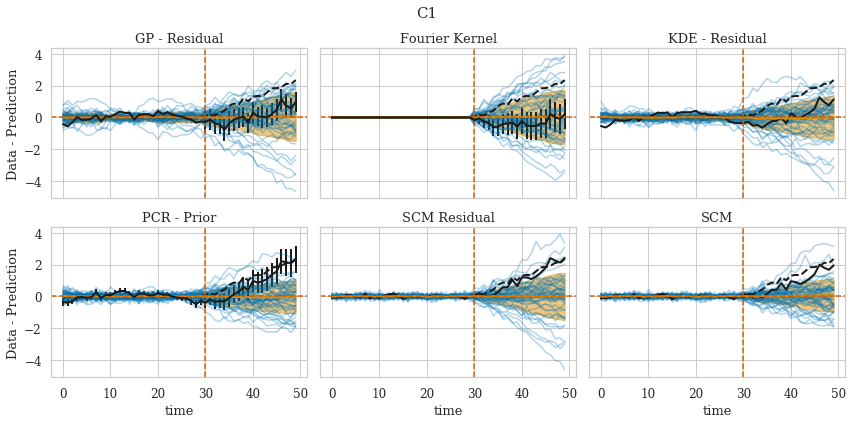

In [104]:
fsize=13
ppp = 95

labels = ['SCM', 'SCM Residual', 'PCR',  'PCR - Prior', 'KDE - Residual',  'GP - Residual'][::-1]
# kkeys = 'scmfits, scmfitsres, pcafits95, pcafitsyj95, kdefitsres, gpfitsres'
# kkeys = 'scmfits, scmfitsres, pcafits99, pcafitsyj99, kdefitsres, gpfitsres'
# if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafits99regnoisepca, pcafitsyj99noisepca, kdefitsres, gpfitspca99res'
if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafits99regnoisepca, pcafitsyj99noisepca, kdefitsres, gpfitspca99res'
elif ppp == 95: kkeys = 'scmfits, scmfitsres, pcafits95regnoisepca, pcafitsyj95noise, kdefitsres, gpfitspca95res'

labels = ['SCM', 'SCM Residual', 'PCR - Prior', 'KDE - Residual',  'Fourier Kernel', 'GP - Residual'][::-1]
kkeys = 'scmfits, scmfitsres, pcafitsyj99noise, kdefitsres, glfits, gpfitspca99res'
kkeys = kkeys.split(', ')[::-1]

i = 0

T = 50
T0 = 30
xx = np.arange(T)
itreated = 0 
titles = ['A0', 'A1', 'B0', 'B1', 'C0', 'C1']
# for idd, dds in enumerate([xu2, xu20, cs22s, cs1010s]):
for idd, dds in enumerate([xu2, xu20, cs22s, cs1010s, pcm50v2, pcm10mix50]):
    fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
    for ik, kk in enumerate(kkeys):

        axis = ax.flatten()[ik]
        dd =  dds[kk]
        diff = dd[:, 0] - dd[:, 1]
        loc = abs(diff).sum(axis=1) < diff.std()*diff.shape[1]*3 #remove large outliers
        diff = diff[loc]
        axis.plot(xx, diff.T, 'C0', alpha=0.3)

        try: axis.errorbar(xx, diff[itreated], dd[itreated][2], color= 'k', lw=2)
        except:     axis.plot(xx, diff[itreated], 'k', lw=2)
        axis.plot(xx, dds['data'][0] - dds['cf'][0], 'k--', lw=2)

        mmean, sstd = diff.mean(axis=0), diff.std(axis=0)
        axis.plot(xx, mmean, 'C1', lw=2)
        axis.fill_between(xx, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
        axis.set_title(labels[ik], fontsize=fsize)
        axis.axhline(0, color='r', ls="--")
        axis.axvline(T0, color='r', ls="--")
    #     axis.set_ylim(-50, 80)

    for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
    for axis in ax[1]:axis.set_xlabel('time', fontsize=fsize)
    for axis in ax[:, 0]:axis.set_ylabel('Data - Prediction', fontsize=fsize)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(titles[idd], fontsize=fsize+2)
    for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
    plt.savefig('../new_figs/%s.png'%titles[idd])
    plt.savefig('../new_figs/%s.pdf'%titles[idd])
    plt.show()

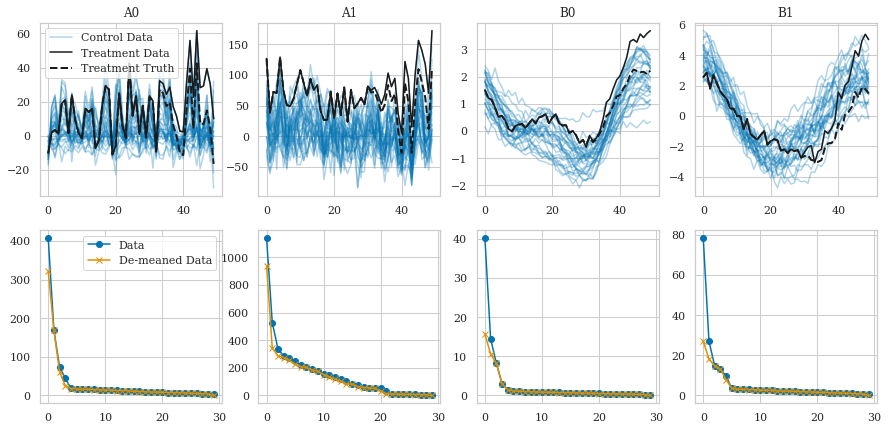

In [27]:
fig, ax = plt.subplots(2, 4, figsize = (15, 7), sharex='row')

titles = ['A0', 'A1', 'B0', 'B1']
for idd, dd in enumerate([xu2, xu20, cs22s, cs1010s]):
    lbl = None
    ax[0, idd].plot(dd['data'].T, 'C0', alpha=0.3)
    if not idd: 
        lbl = 'Control Data'
        ax[0, idd].plot(dd['data'][0], 'C0', alpha=0.3, label=lbl)
    if not idd: lbl = 'Treatment Data'
    ax[0, idd].plot(dd['data'][0], 'k-', label=lbl)
    if not idd: lbl = 'Treatment Truth'
    ax[0, idd].plot(dd['cf'][0], 'k--', lw=2, label=lbl)
    
    if not idd: lbl = 'Data'
    ax[1, idd].plot(np.linalg.svd(dd['data'])[1][:], marker='o', label=lbl)
    if not idd: lbl = 'De-meaned Data'
    ax[1, idd].plot(np.linalg.svd(dd['data'] - dd['data'].mean(axis=0))[1][:], marker='x', label=lbl)
    ax[0, idd].set_title(titles[idd])
    if not idd: 
        for axis in ax[:, 0]: axis.legend()


## plot single

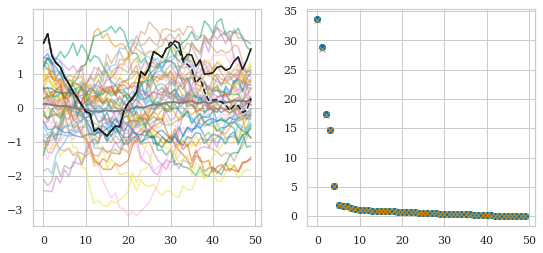

In [28]:
fsize=12

# for idd, dd in enumerate([xu2, xu20, cs22s, cs1010s]):
dd = pcm50v2.copy()

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(dd['data'].T, alpha=0.5)
ax[0].plot(dd['data'][0], 'k')
ax[0].plot(dd['data'].mean(axis=0), 'gray', lw=2)
ax[0].plot(dd['cf'][0], 'k--')

ax[1].plot(np.linalg.svd(dd['data'])[1], 'o')
ax[1].plot(np.linalg.svd(dd['data'] - dd['data'].mean(axis=0))[1], 'x')

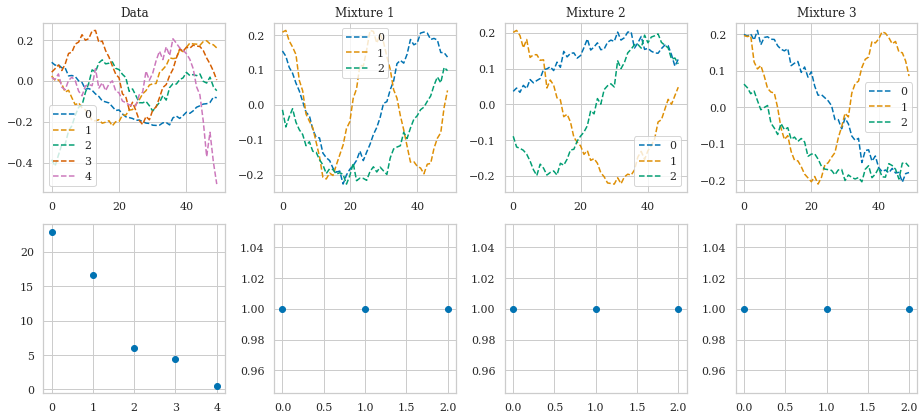

In [29]:
fsize=12

titles = ['A0', 'A1', 'B0', 'B1']
# for idd, dd in enumerate([xu2, xu20, cs22s, cs1010s]):
dd = pcm50v2.copy()

fig, ax = plt.subplots(2, 4, figsize=(13, 6))
pca = PCA(5).fit(dd['data'])
for ij, j in enumerate(pca.components_):
    ax[0, 0].plot(j, '--', label=ij)
    ax[0, 0].legend()
ax[0, 0].set_title('Data')
ax[1, 0].plot(pca.explained_variance_, 'o')
for i in range(1, 4):
    for ij, j in enumerate(dd['components'][i-1]):
        ax[0, i].plot(j, '--', label=ij)
        ax[0, i].legend() 
    ax[1, i].plot(dd['eigvalues'][i-1], 'o')
    ax[0, i].set_title('Mixture %d'%i)
plt.tight_layout()# for idd, dd in enumerate([pcm50]):

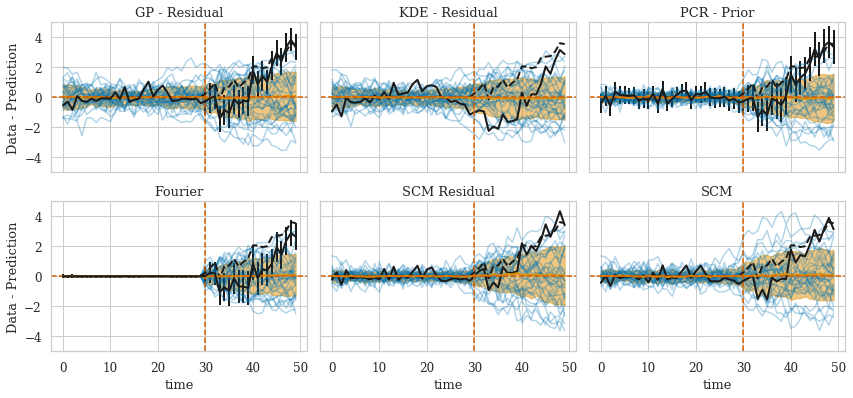

In [90]:
fsize=13
ppp = 99

labels = ['SCM', 'SCM Residual', 'Fourier',  'PCR - Prior', 'KDE - Residual',  'GP - Residual'][::-1]
# kkeys = 'scmfits, scmfitsres, pcafits95, pcafitsyj95, kdefitsres, gpfitsres'
# kkeys = 'scmfits, scmfitsres, pcafits99, pcafitsyj99, kdefitsres, gpfitsres'
if ppp == 99:  kkeys = 'scmfits, scmfitsres, glfits, pcafitsyj99noise, kdefitsres, gpfitspca99res'
elif ppp == 95: kkeys = 'scmfits, scmfitsres, glfits, pcafitsyj99noise, kdefitsres, gpfitspca95res'
kkeys = 'scmfits, scmfitsres, glfits, pcafitsyj99noise, kdefitsres, gpfitspca95res'
kkeys = kkeys.split(', ')[::-1]

i = 0

T = 50
T0 = 30
xx = np.arange(T)
itreated = 0 
titles = ['']
# for idd, dds in enumerate([xu2, xu20, cs22s, cs1010s]):
# for idd, dds in enumerate([pcm10mix50]):
for idd, dds in enumerate([cs1010s]):
    fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
    for ik, kk in enumerate(kkeys):

        axis = ax.flatten()[ik]
        dd =  dds[kk]
        diff = dd[:, 0] - dd[:, 1]
        loc = abs(diff).sum(axis=1) < diff.std()*diff.shape[1]*3
        diff = diff[loc]
        axis.plot(xx, diff.T, 'C0', alpha=0.3)

        try: axis.errorbar(xx, diff[itreated], dd[itreated][2], color= 'k', lw=2)
        except:     axis.plot(xx, diff[itreated], 'k', lw=2)
        axis.plot(xx, dds['data'][0] - dds['cf'][0], 'k--', lw=2)

        mmean, sstd = diff.mean(axis=0), diff.std(axis=0)
        axis.plot(xx, mmean, 'C1', lw=2)
        axis.fill_between(xx, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
        axis.set_title(labels[ik], fontsize=fsize)
        axis.axhline(0, color='r', ls="--")
        axis.axvline(T0, color='r', ls="--")
        axis.set_ylim(-5, 5)

    for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
    for axis in ax[1]:axis.set_xlabel('time', fontsize=fsize)
    for axis in ax[:, 0]:axis.set_ylabel('Data - Prediction', fontsize=fsize)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(titles[idd], fontsize=fsize+2)
    for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
#     plt.savefig('../new_figs/%s.png'%titles[idd])
#     plt.savefig('../new_figs/%s.pdf'%titles[idd])
    plt.show()

array([[-0.4349794 ,  0.0423416 , -0.64883212, ...,  3.16656701,
         3.89324689,  3.13185393],
       [ 0.05219918,  0.18606383, -0.73126917, ..., -0.17076605,
        -0.24995512,  0.08973618],
       [-0.17561426, -0.02959686, -0.13982655, ...,  0.66994982,
         0.23847158,  1.23014562],
       ...,
       [-0.44092996, -1.02417316, -0.0343226 , ..., -0.24585409,
        -1.37076055, -0.89835475],
       [ 0.60099955, -0.02621351,  0.98494287, ...,  0.8908103 ,
         0.6958772 ,  1.43930995],
       [-0.35913918, -0.23317392,  0.30405095, ...,  0.767838  ,
         0.3010131 ,  0.12006811]])